## ロジスティック回帰スクラッチ
>ロジスティック回帰のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。
>以下に雛形を用意してあります。このScratchLogisticRegressionクラスにコードを書き加えていってください。推定関係のメソッドは線形回帰と異なり、ラベルを出力するpredictメソッドと、確率を出力するpredict_probaメソッドの2種類を作成します。

### 完成品

In [1]:
import numpy as np

In [2]:
class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録

    """
    def __init__(self, num_iter, lr, bias, verbose):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.bias = bias
        self.verbose = verbose
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
        # θとXを記録する配列を用意
        self.theta_ = np.empty(0)
        self.X_ = np.empty(0)
        
        
    def fit(self, X, y, alpha=0.01,lam=1, X_val=None, y_val=None):
        """
        ロジスティック回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        loss_count = False
        
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            if X_val is not None and y_val is not None:
                loss_count = True
            else:
                print("Warning　：　テストデータの入力がないため、学習過程が記録できません。")
            
        if loss_count:
            # 定数用のx＝１を作成。
            ones_for_constant_val = np.ones(X_val.shape[0]).reshape(-1,1)
            X_val = np.concatenate([ones_for_constant_val.reshape(-1,1), X_val], axis=1)

            m_val = X_val.shape[0]
            
            y = y.reshape(-1,1)
            y_val = y_val.reshape(-1,1)

            # 誤差保管用リスト
            train_loss = []
            test_loss = []
    
        # 定数用のx＝１を作成。
        if self.X_.size == 0:
            ones_for_constant = np.ones(X.shape[0]).reshape(-1,1)
            self.X_ = np.concatenate([ones_for_constant.reshape(-1,1), X], axis=1)

        #  θ の用意
        if self.theta_.size == 0:
            # 特徴量の数
            n = self.X_.shape[1]
            self.theta_ = np.random.rand(n)
            
            
        # サンプル数
        m = self.X_.shape[0]
        
        for _ in range(self.iter):
            error = self._error_calculation(self.X_, y)
            self._gradient_descent(self.X_, y, X_val, y_val, error, alpha=alpha, lam=lam)
            
            if loss_count:
    
                h = self._linear_hypothesis(self.X_)
                # クロスエントロピー損失関数のサンプル数分の総和とλ/2mのθ^2の特徴量分の総和
                train_j = (np.sum(-y*np.log(h) - (1-y)*np.log(1-h),axis=0)/m)+((lam/(2*m))*np.sum(np.square(self.theta_)))#self.theta_[1:]
                train_loss.append(train_j)
                
                h_val = self._linear_hypothesis(X_val)
                # クロスエントロピー損失関数のサンプル数分の総和とλ/2mのθ^2の特徴量分の総和
                test_j = (np.sum(-y_val*np.log(h_val) - (1-y_val)*np.log(1-h_val),axis=0)/m_val )+((lam/(2*m_val))*np.sum(np.square(self.theta_)))#self.theta_[1:]
                test_loss.append(test_j)
                
        if loss_count:
            self.loss = np.array(train_loss)
            self.val_loss = np.array(test_loss)
            
    
    def _linear_hypothesis(self, X, comment=False):
        """
        線形の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果

        """
        # 定数用のx＝１を作成。
        if self.X_.size == 0:
            ones_for_constant = np.ones(X.shape[0]).reshape(-1,1)
            X = np.concatenate([ones_for_constant.reshape(-1,1), X], axis=1)
            self.X_ = X
            
        #  θ の用意
        if self.theta_.size == 0:
            # 特徴量の数
            n = self.X_.shape[1]
            # θ の用意
            self.theta_ = np.random.rand(n)
        
        if comment:
            print("Xの値:\n{}".format(self.X_))
            print("Xの形:　{}".format(self.X_.shape))
            print("θの値: {}".format(self.theta_))
            print("θの形: {}".format(self.theta_.shape))
        
        linear_h = np.sum(self.theta_.T*X, axis=1).reshape(-1,1)
        sigmoid = 1/(1+np.exp(-linear_h))
        
        return sigmoid
    
    
    def _gradient_descent(self, X, y, X_val, y_val, error, alpha = 0.01, lam=1):
        """
        線形の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果

        """
        # サンプル数
        m = X.shape[0]
        
        # バイアス項用のθをゼロにする
        t_n = self.theta_.shape[0]
        zero_one_for_theta = np.concatenate([np.array([0]).reshape(-1,1), np.ones(t_n-1).reshape(-1,1)], axis=0).reshape(-1,)
        
        reg_theta = self.theta_*zero_one_for_theta
        
        self.theta_ = self.theta_ - alpha * (np.sum(error*X, axis=0)/m + (lam/m)*reg_theta)
        
        return
    
    
    def _error_calculation(self, X, y):
        """
        線形の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果

        """        
        #　仮定関数作成
        linear_h = np.sum(self.theta_.T*X, axis=1).reshape(-1,1)
        sigmoid = 1/(1+np.exp(-linear_h))
        #h = self._linear_hypothesis(X)
        
        # 仮定関数マイナス正解（すでに微分している形）
        error = sigmoid - y.reshape(-1,1)
        
        return error
    
    
    def predict(self, X, threshold=0.5):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        pred = np.where(self.predict_proba(X) <  threshold, 0, 1).reshape(-1,)

        return pred
    
    
    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        # 定数用のx＝１を作成。
        ones_for_constant = np.ones(X.shape[0]).reshape(-1,1)
        X = np.concatenate([ones_for_constant.reshape(-1,1), X], axis=1)

        # 仮定関数の出力が推定結果
        linear_h = np.sum(self.theta_.T*X, axis=1).reshape(-1,1)
        pred_proba = 1/(1+np.exp(-linear_h))
        
        return pred_proba

In [3]:
# 検証用データ

# サンプル 4個　　特徴量　2
X_q1 = np.array([[1,2], [3,4], [5,6], [7,8]])

# サンプル ５個　　特徴量　１   
# X_train = np.array([[1],[2],[3],[4],[5]])

# サンプル３個　特徴量　１ 
#X_train = np.array([[1], [2], [3]])

# サンプル３個　特徴量　２ 
X_train = np.array([[1,2], [3,4], [5,6]])

# サンプル４個　特徴量３
#X_train = np.array([[1,2,7], [3,4,8], [5,6,9], [10,11,12]])


# サンプル　１    
# y_train = np.array([1])

# サンプル　２ 
#y_train = np.array([0, 1])

# サンプル　３
y_train = np.array([0, 1, 0])

# サンプル　4
#y_train = np.array([[0], [1], [0], [0]])


# サンプル５個　特徴量　１    
# X_test = np.array([[1],[2],[3],[4],[5]])

# サンプル３個　特徴量　１ 
#X_test  = np.array([[1], [2], [3]])

# サンプル３個　特徴量２ 
X_test  = np.array([[2,1], [4,3], [6,5]])

# サンプル４個　特徴量３
#X_test  = np.array([[1,2,7], [3,4,8], [5,6,9], [10,11,12]])


# サンプル　１    
#y_test  = np.array([1])

# サンプル　２ 
#y_test  = np.array([0, 1])

# サンプル　３
y_test = np.array([1,0,1])


alpha = 0.03

## 【問題1】仮定関数  

>ロジスティック回帰の仮定関数のメソッドをScratchLogisticRegressionクラスに実装してください。
>ロジスティック回帰の仮定関数は、線形回帰の仮定関数を シグモイド関数 に通したものです。シグモイド関数は以下の式で表されます。
>
>$
g(z) = \frac{1}{1+e^{−z}}.
$
>
>線形回帰の仮定関数は次の式でした。
>
>$
h_\theta(x) = \theta^T \cdot x.
$
>
>まとめて書くと、ロジスティック回帰の仮定関数は次のようになります。
>
>$
h_\theta(x) = \frac{1}{1+e^{−\theta^T \cdot x}}.
>
>x : 特徴量ベクトル
>
>θ : パラメータ（重み）ベクトル

In [4]:
# 【問題１】
# __init__ に self.theta_ = np.empty(0)、self.X_ = np.empty(0) を追加して初期化
# _linear_hypothesis 内にて self.X_ が空白の場合に 先頭行に １ を追加するように作成

# 適当にインスタンス化
logistic_1 = ScratchLogisticRegression(10,2,True,True)

h_return = logistic_1._linear_hypothesis(X_q1, comment=True)

# h の要素数はサンプル数と等しい。０〜１までの確率で表される。
print("hの値:\n{}".format(h_return))
print("hの形: {}".format(h_return.shape))


Xの値:
[[1. 1. 2.]
 [1. 3. 4.]
 [1. 5. 6.]
 [1. 7. 8.]]
Xの形:　(4, 3)
θの値: [0.34818102 0.52454324 0.71177081]
θの形: (3,)
hの値:
[[0.90856731]
 [0.9915817 ]
 [0.99928429]
 [0.99993958]]
hの形: (4, 1)


## 【問題2】最急降下法  
>最急降下法により学習させる実装を行なってください。以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fit
メソッドから呼び出すようにしてください。 
>
>$
\theta_j := \theta_j - \alpha \frac{\partial J(\theta)}{\partial \theta_j}
$  
>
>$
\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)}  ,j = 0
$  
>
>$
\frac{\partial J(\theta)}{\partial \theta_j} = \biggl(\frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)} \biggr) + \frac{λ}{m}\theta_j　 ,j\geq 1
$
>
>α : 学習率  
>i : サンプルのインデックス  
>j : 特徴量のインデックス  
>m : 入力されるデータの数  
>hθ() : 仮定関数  
>x : 特徴量ベクトル  
>θ : パラメータ（重み）ベクトル  
>x(i) : i番目のサンプルの特徴量ベクトル  
>y(i) : i番目のサンプルの正解ラベル  
>θj : j番目のパラメータ（重み）  
>λ : 正則化パラメータ  

In [28]:
# 誤差の計算を行う_error_calculation()メソッドを作成し、fitメソッドから呼び出した上で
# _gradient_descent メソッドの引数として使用。

# インスタンス化
logistic = ScratchLogisticRegression(10,2,True,False)
logistic.fit(X_train, y_train, alpha=alpha)

## 【問題3】推定  
>推定する仕組みを実装してください。ScratchLogisticRegressionクラスの雛形に含まれるpredictメソッドとpredict_probaメソッドに書き加えてください。
>仮定関数 hθ(x) の出力がpredict_probaの返り値、さらにその値に閾値を設けて1と0のラベルとしたものがpredictの返り値となります。



In [6]:
print(logistic.predict_proba(X_test))

[[0.54166182]
 [0.49567875]
 [0.44976867]]


In [29]:
print(logistic.predict(X_test, threshold=0.5))

[0 0 0]


## 【問題4】目的関数  
>以下の数式で表されるロジスティック回帰の 目的関数（損失関数） を実装してください。そして、これをself.loss, self.val_lossに記録するようにしてください。
>
>なお、この数式には正則化項が含まれています。
>
>$
J(\theta)=  \frac{1}{m}  \sum_{i=1}^{m}[−y^{(i)} log(h_θ(x^{(i)})) − (1−y^{(i)}) log(1−h_θ(x^{(i)}))] +
\frac{λ}{2m}\sum_{j=1}^n
θ^2_j.\\
$
>
>＊数式が見切れる場合、DIVERを全画面にして御覧ください。
>
>m : 入力されるデータの数
>hθ() : 仮定関数
>x : 特徴量ベクトル
>θ : パラメータ（重み）ベクトル
>x(i) : i番目のサンプルの特徴量ベクトル
>y(i) : i番目のサンプルの正解ラベル
>θj : j番目のパラメータ（重み）
>n : 特徴量の数
>λ : 正則化パラメータ

In [30]:
# インスタンス化
logistic_4 = ScratchLogisticRegression(10,2,True,True)
logistic_4.fit(X_train, y_train, alpha=alpha, X_val=X_test, y_val=y_test)

print("目的関数（損失関数）　トレーニングデータ:\n{}".format(logistic_4.loss))
print("目的関数（損失関数）　テストデータ:\n{}".format(logistic_4.val_loss))

目的関数（損失関数）　トレーニングデータ:
[[3.30507344]
 [2.92209454]
 [2.55427295]
 [2.2046737 ]
 [1.87805233]
 [1.58146575]
 [1.32428317]
 [1.11624424]
 [0.96269561]
 [0.85995838]]
目的関数（損失関数）　テストデータ:
[[1.82762018]
 [1.62956966]
 [1.44203099]
 [1.26684494]
 [1.10687539]
 [0.96634782]
 [0.8507733 ]
 [0.76560001]
 [0.71307949]
 [0.68938112]]


## 【問題5】学習と推定  
>機械学習スクラッチ入門のSprintで用意したirisデータセットのvirgicolorとvirginicaの2値分類に対してスクラッチ実装の学習と推定を行なってください。
>scikit-learnによる実装と比べ、正しく動いているかを確認してください。
>AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。



In [31]:
import pandas as pd

In [32]:
from decimal import Decimal, ROUND_HALF_UP

# Sprint 1 で作成した関数
def scratch_train_test_split(X, y, train_size=0.8,):
    """
    検証データを分割する。

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, )
      正解値
    train_size : float (0<train_size<1)
      何割をtrainとするか指定

    Returns
    ----------
    X_train : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    X_test : 次の形のndarray, shape (n_samples, n_features)
      検証データ
    y_train : 次の形のndarray, shape (n_samples, )
      訓練データの正解値
    y_test : 次の形のndarray, shape (n_samples, )
      検証データの正解値
    """
    # return none では戻り値をアンパック代入できないため予め引数用配列を用意
    X_train = np.empty(0)
    X_test = np.empty(0)
    y_train = np.empty(0)
    y_test = np.empty(0)
    
    if (type(X) is not np.ndarray)or(type(y) is not np.ndarray):
        print("ERROR: Xまたはyがndarrayではありません。")
    elif (X.ndim !=2)or(y.ndim !=1):
        print("ERROR: Xまたはyの次元が異なります。")
    else:
        # 入力データの行数
        X_row = X.shape[0]
        y_row = len(y)
        
        if not X_row == y_row:
            print("ERROR: Xとyの行数が違います。行数を合わせてください。")
        else:
            # trainの行数を計算。四捨五入するためにDecimal型に変換。
            train_row = Decimal(X_row*train_size)
            # 四捨五入した後、int型に戻す
            train_row = int(train_row.quantize(Decimal('0'), rounding=ROUND_HALF_UP))

            X_columns = X.shape[1]
            
            # concatenateを用いて２つのリストを列方向に結合する
            Xy_array = np.concatenate((X, y.reshape(-1,1)), axis=1)
            Xy_rand = np.random.permutation(Xy_array)
            
            X_train = Xy_rand[:train_row,:X_columns]
            X_test = Xy_rand[train_row:,:X_columns]
            y_train = Xy_rand[:train_row,X_columns]
            y_test = Xy_rand[train_row:,X_columns]
        
    return X_train, X_test, y_train, y_test

In [33]:
# scikit-learn から　iris データセットを読み込む
from sklearn.datasets import load_iris

# iris データセットを変数に格納する
data = load_iris()

# 行と列のインデックス用のリストを用意
iris_data_columns=['sepal_length', 'sepal_width','petal_length','petal_width']
iris_target_columns=['Species',]

# pandas のデータフレームにする
X_data = pd.DataFrame(data=data['data'], columns=iris_data_columns)
y_data = pd.DataFrame(data=data['target'], columns=iris_target_columns)

# Xとyを列方向に結合
df = pd.concat([X_data, y_data], axis=1)

# 条件に従って抜き出し
df_ex = df[df['Species'] >=1]

# 処理用
X_iris = np.array(df_ex[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']])
y_iris = np.array(df_ex['Species']) - 1#　0,1にしたいので


In [35]:
X_train_i, X_test_i, y_train_i, y_test_i = scratch_train_test_split(X_iris, y_iris, train_size=0.8)

print("X_trainの形は：{}".format(X_train_i.shape))
print("y_trainの形は：{}".format(y_train_i.shape))
print("X_testの形は：{}".format(X_test_i.shape))
print("y_testの形は：{}".format(y_test_i.shape))


X_trainの形は：(80, 4)
y_trainの形は：(80,)
X_testの形は：(20, 4)
y_testの形は：(20,)


In [36]:
from sklearn.preprocessing import StandardScaler

# 標準化クラスをインスタンス化
scaler = StandardScaler()

# 配列Xの平均と分散を計算して記憶する
scaler.fit(X_train_i)

# 標準化
X_train_i_scaled = scaler.transform(X_train_i)
X_test_i_scaled = scaler.transform(X_test_i)

In [37]:
# インスタンス化
logistic_5 = ScratchLogisticRegression(10000,2,True,True)
logistic_5.fit(X_train_i_scaled, y_train_i, alpha=0.01, lam=0.1, X_val=X_test_i_scaled, y_val=y_test_i)#lam=100
#logistic_5.fit(X_train_i_scaled, y_train_i, alpha=0.1, lam=0.1, X_val=X_test_i_scaled, y_val=y_test_i)#lam=100


In [38]:
print("推定値（確率）:\n{}".format(logistic_5.predict_proba(X_test_i_scaled)))

y_pred_i = logistic_5.predict(X_test_i_scaled, threshold=0.5)
print("推定値（閾値あり）:\n{}".format(y_pred_i))

推定値（確率）:
[[9.96346690e-01]
 [5.23517918e-04]
 [5.95914569e-01]
 [6.08334903e-03]
 [1.05488470e-01]
 [6.92522011e-02]
 [7.93792544e-01]
 [1.23737330e-04]
 [5.40793009e-02]
 [2.92386979e-01]
 [9.65154568e-05]
 [2.27774123e-02]
 [9.93327376e-01]
 [9.97525777e-01]
 [9.85158470e-01]
 [4.13249371e-04]
 [4.34165319e-01]
 [8.04058045e-01]
 [3.96299210e-02]
 [9.45033858e-01]]
推定値（閾値あり）:
[1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1]


In [39]:
print("目的関数（損失関数）　トレーニングデータ:\n{}".format(logistic_5.loss))
print("目的関数（損失関数）　テストデータ:\n{}".format(logistic_5.val_loss))

目的関数（損失関数）　トレーニングデータ:
[[0.38701982]
 [0.38649517]
 [0.3859724 ]
 ...
 [0.09508048]
 [0.0950793 ]
 [0.09507812]]
目的関数（損失関数）　テストデータ:
[[0.45139812]
 [0.45105179]
 [0.45070642]
 ...
 [0.19218756]
 [0.19218768]
 [0.19218779]]


In [40]:
#from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [41]:
# 精度をまとめるための空のリストを用意
verification_logistic =[ 'MyLogisticRegression']


#Accuracy（正解率）
verification_logistic.append(accuracy_score(y_test_i, y_pred_i))

#Precision（適合率）
verification_logistic.append(precision_score(y_test_i, y_pred_i))

#Recall（再現率）
verification_logistic.append(recall_score(y_test_i, y_pred_i))

#F値
verification_logistic.append(f1_score(y_test_i, y_pred_i))


print(verification_logistic)

['MyLogisticRegression', 0.9, 0.875, 0.875, 0.875]


### Scikit-learnによる推定

In [42]:
#ロジスティック回帰

from sklearn.linear_model import LogisticRegression


# 精度をまとめるための空のリストを用意
verification_logistic_sk =[ 'sklearn_LogisticRegression']


logistic_sk = LogisticRegression()
logistic_sk.fit(X_train_i_scaled, y_train_i)
y_pred_i_sk = logistic_sk.predict(X_test_i_scaled)
print("ロジスティック回帰による予測値\n{}".format(y_pred_i_sk))

#Accuracy（正解率）
verification_logistic_sk.append(accuracy_score(y_test_i, y_pred_i_sk))

#Precision（適合率）
verification_logistic_sk.append(precision_score(y_test_i, y_pred_i_sk))

#Recall（再現率）
verification_logistic_sk.append(recall_score(y_test_i, y_pred_i_sk))

#F値
verification_logistic_sk.append(f1_score(y_test_i, y_pred_i_sk))


print(verification_logistic_sk)

ロジスティック回帰による予測値
[1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1.]
['sklearn_LogisticRegression', 0.9, 0.875, 0.875, 0.875]


In [43]:
# 表を作成するために計算結果を２次元配列にする
verification_result = [
            verification_logistic, 
            verification_logistic_sk, 
        ]

# 行と列のインデックスようのリストを用意
data_columns=['Model', 'Accuracy（正解率）', 'Precision（適合率）', 'Recall（再現率）', 'F値' ]

# pandas のデータフレームにする
df_verification = pd.DataFrame(data=verification_result, columns=data_columns)

display(df_verification)

,Model,Accuracy（正解率）,Precision（適合率）,Recall（再現率）,F値
0,MyLogisticRegression,0.9,0.875,0.875,0.875
1,sklearn_LogisticRegression,0.9,0.875,0.875,0.875


In [44]:
print("自作関数の推定値（閾値あり）:\n{}".format(y_pred_i))
print("ロジスティック回帰による予測値\n{}".format(y_pred_i_sk))

自作関数の推定値（閾値あり）:
[1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1]
ロジスティック回帰による予測値
[1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1.]


## 【問題6】学習曲線のプロット  
>学習曲線を見て損失が適切に下がっているかどうか確認してください。



In [45]:
import matplotlib.pyplot as plt

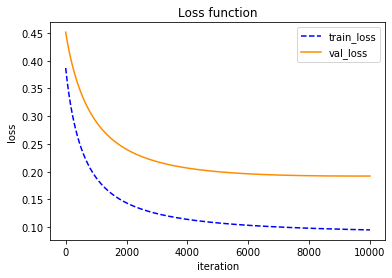

In [46]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.set_title('Loss function')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
 
ax.plot(logistic_5.loss, 'k--', color='b', label='train_loss')
ax.plot(logistic_5.val_loss, 'k', color='darkorange', label='val_loss')
 
ax.legend(loc='best')

## 【問題7】決定領域の可視化  
>決定領域を可視化してください。

特徴量４つで学習を行っってきたが、グラフ化が難しいため、改めて特徴量２つで学習。

In [49]:
# 処理用
X_2dris_2d = np.array(df_ex[['petal_length','petal_width']])#'sepal_length', 'sepal_width', 'petal_length','petal_width'
y_2dris_2d = np.array(df_ex['Species']) - 1#　0,1にしたいので −１

X_train_2d, X_test_2d, y_train_2d, y_test_2d = scratch_train_test_split(X_2dris_2d, y_2dris_2d, train_size=0.8)

# 標準化クラスをインスタンス化
scaler_2d = StandardScaler()

# 配列Xの平均と分散を計算して記憶する
scaler_2d.fit(X_train_2d)

# 標準化
X_train_2d_scaled = scaler_2d.transform(X_train_2d)
X_test_2d_scaled = scaler_2d.transform(X_test_2d)


In [50]:
# インスタンス化
logistic_7 = ScratchLogisticRegression(10000,2,True,True)
logistic_7.fit(X_train_2d_scaled, y_train_2d, alpha=0.01, lam=0.1, X_val=X_test_2d_scaled, y_val=y_test_2d)#lam=100


In [51]:
y_pred_2d = logistic_7.predict(X_test_2d_scaled, threshold=0.5)
print("自作関数の推定値（閾値あり）:\n{}".format(y_pred_2d))

#Accuracy（正解率）
print(accuracy_score(y_test_2d, y_pred_2d))

#Precision（適合率）
print(precision_score(y_test_2d, y_pred_2d))

#Recall（再現率）
print(recall_score(y_test_2d, y_pred_2d))

#F値
print(f1_score(y_test_2d, y_pred_2d))

自作関数の推定値（閾値あり）:
[1 0 1 1 0 1 1 0 0 0 1 0 1 0 1 1 1 0 1 0]
1.0
1.0
1.0
1.0


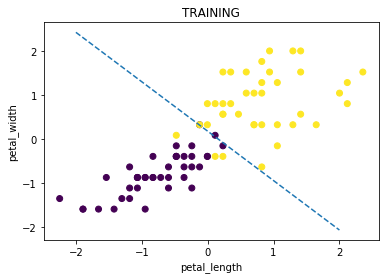

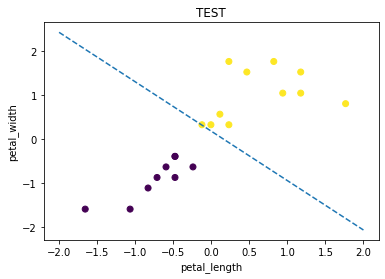

In [52]:
plt.title('TRAINING')
plt.xlabel('petal_length')
plt.ylabel('petal_width')

x0 = np.linspace(-2, 2, 100)
plt.scatter(X_train_2d_scaled[:,0],X_train_2d_scaled[:,1], c=y_train_2d)

Y = (0.5 - logistic_7.theta_[1]*x0  - logistic_7.theta_[0]) / logistic_7.theta_[2]
plt.plot(x0, Y, linestyle= 'dashed')

plt.show()

plt.title('TEST')
plt.xlabel('petal_length')
plt.ylabel('petal_width')

x0 = np.linspace(-2, 2, 100)
plt.scatter(X_test_2d_scaled[:,0],X_test_2d_scaled[:,1], c=y_test_2d)

Y = (0.5 - logistic_7.theta_[1]*x0  - logistic_7.theta_[0]) / logistic_7.theta_[2]
plt.plot(x0, Y, linestyle= 'dashed')

plt.show()